# Building and Training a model on the `make_moons` toy dataset.

In [52]:
# Import modules
import torch
from torch import nn
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import requests

# check torch version
torch.__version__

'2.2.1+cu121'

In [53]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


# Importing Dataset from Scikit-Learn

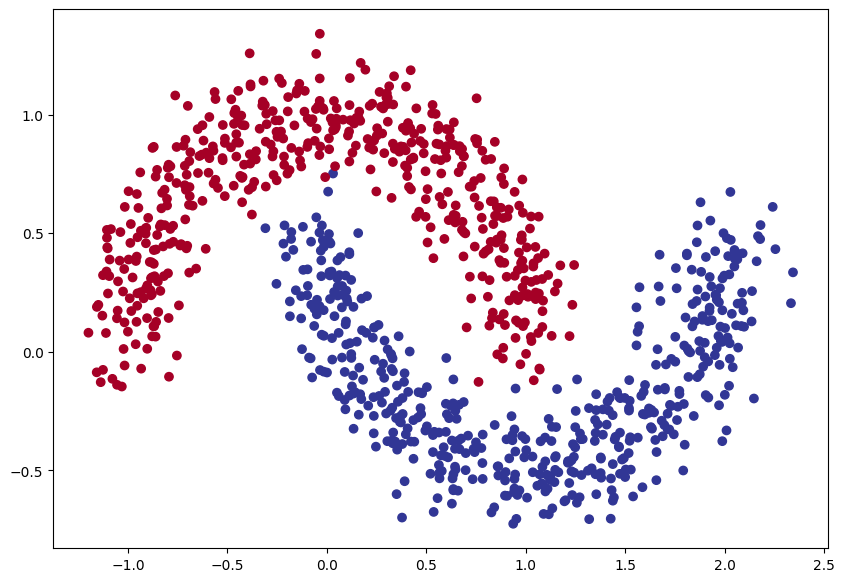

In [54]:
# import modules for dataset and for splitting data
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create data
X_moons, y_moons = make_moons(
    n_samples=1000,
    noise=0.125,
    random_state=28
)

# turn data into tensors
X_moons, y_moons = torch.from_numpy(X_moons).type(torch.float32), torch.from_numpy(y_moons).type(torch.float32)

# split data into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_moons,
    y_moons,
    test_size=0.2,
    random_state=28
)

# plot dataset
plt.figure(figsize=(10,7))
plt.scatter(
    X_moons[:, 0],
    X_moons[:, 1],
    c=y_moons,
    cmap=plt.cm.RdYlBu
)

# Building model (with `nn.Sequential`)

In [55]:
# Build Model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [56]:
# untrained predictions
torch.round(model_0(X_test)[:10])

tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], grad_fn=<RoundBackward0>)

# Training Model

In [57]:
# create loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function combined with the BCE Loss

# define accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# create optimizer function
optimizer = torch.optim.SGD(
    model_0.parameters(),
    lr=0.1
)

In [58]:
# set manual seed for training
torch.manual_seed(28)
torch.cuda.manual_seed(28)

# set no. of epochs
epochs = 4000

# put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Write train test loop
for epoch in range(epochs):
  # Train
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(
    y_true = y_train,
    y_pred = y_pred
  )

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  # Test
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # print whats happening
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.6859, Acc: 51.00%, Test Loss: 0.6910, Test Acc: 46.00%
Epoch: 1000, Loss: 0.2169, Acc: 89.75%, Test Loss: 0.2565, Test Acc: 86.00%
Epoch: 2000, Loss: 0.2139, Acc: 89.62%, Test Loss: 0.2533, Test Acc: 86.00%
Epoch: 3000, Loss: 0.0765, Acc: 98.25%, Test Loss: 0.0919, Test Acc: 97.00%


# Evaluating and plotting results

In [59]:
# Evaluating Model
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

# comparing predictions and actual values
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 1.]),
 tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 1.]))

In [60]:
# Download helper functions from Learn PyTorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

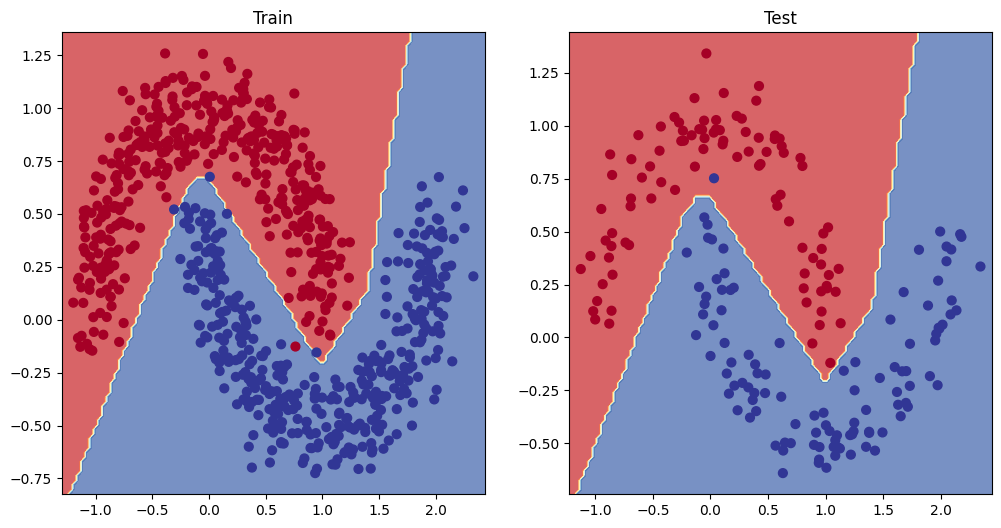

In [62]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)